# This is the clean version of Test_Work.ipynb
It contains the same code, but with only the core components of the generator 

## Modules Used

In [11]:
import pandas as pd
import numpy as np
from datetime import timedelta
import random
import duckdb as ddb

# Further Analysis
import matplotlib.pyplot as plt
# import plotly.express as px



## Sales Invoices

In [29]:
def generate_sales_data(num_records, start_date, end_date, regions_df, products_df):
    # Lists to store generated data
    order_dates = []
    shipment_dates = []
    regions = []
    countries = []
    product_types = []
    unit_prices = []
    unit_costs = []
    quantities = []

    # Generate data for each record
    for _ in range(num_records):
 
        region_row = regions_df.sample().iloc[0]
        regions.append(region_row['StoreID'])
        countries.append(region_row['StoreName'])

        # Randomly select product and corresponding unit price and cost
        product_row = products_df.sample().iloc[0]
        product_types.append(product_row['Product'])
        unit_prices.append(product_row['Unit Price'])
        unit_costs.append(product_row['Unit Cost'])

        # Random order date between start and end date
        random_date = start_date + timedelta(days=np.random.randint(0, (end_date-start_date).days))
        order_dates.append(random_date)
        # Ship date between 1 and 50 days after order date
        shipment_dates.append(random_date + timedelta(days=np.random.randint(1, 51)))

        # Random quantity between 1000 and 10000
        quantities.append(np.random.randint(1000, 10001))


    sales_df = pd.DataFrame({
        'Order_Date': order_dates,
        'Shipment_Date': shipment_dates,
        'StoreID': regions,
        'StoreName': countries,
        'Product_Type': product_types,
        'Unit_Price': unit_prices,
        'Unit_Cost': unit_costs,
        'Quantity': quantities,
        'Revenue': np.array(unit_prices) * np.array(quantities),
        'Total_Cost': np.array(unit_costs) * np.array(quantities)
    })

    sales_df['Total Profit'] = sales_df['Revenue'] - sales_df['Total_Cost']

    return sales_df


regions_data = {
    'StoreID': [1,2,3,4,5,6,7,8,9,10],
    'StoreName': ["StoreNY","StoreLA","StorePA","StoreKY","StoreWA","StoreDC","StoreFL","StoreAL","StoreTX","StoreMN",]
}
regions_df = pd.DataFrame(regions_data)

products_data = {
    'Product': ["Office Supplies","Vegetables","Fruits","Cosmetics","Cereal","Baby Food","Beverages","Snacks","Clothes","Household","Personal Care","Meat"],
    'Unit Price': [651.21,154.06,9.33,437.2,205.7,255.28,47.45,152.58,109.28,668.27,81.73,421.89],
    'Unit Cost': [524.96,90.93,6.92,263.33,117.11,159.42,31.79,97.44,35.84,502.54,56.67,364.69]
}

products_df = pd.DataFrame(products_data)

start_date = pd.Timestamp('2015-01-01')
end_date = pd.Timestamp('2021-12-31')
num_records = 1000

sales_df = generate_sales_data(num_records, start_date, end_date, regions_df, products_df)

print(sales_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order_Date     1000 non-null   datetime64[ns]
 1   Shipment_Date  1000 non-null   datetime64[ns]
 2   StoreID        1000 non-null   int64         
 3   StoreName      1000 non-null   object        
 4   Product_Type   1000 non-null   object        
 5   Unit_Price     1000 non-null   float64       
 6   Unit_Cost      1000 non-null   float64       
 7   Quantity       1000 non-null   int64         
 8   Revenue        1000 non-null   float64       
 9   Total_Cost     1000 non-null   float64       
 10  Total Profit   1000 non-null   float64       
dtypes: datetime64[ns](2), float64(5), int64(2), object(2)
memory usage: 86.1+ KB
None


## Purchase Orders

In [30]:
sales_data = sales_df
sales_data = sales_data.sort_values(by=['Order_Date'])



product_types = ['Cereal', 'Snacks', 'Beverages', 'Baby Food', 'Meat', 'Fruits', 'Vegetables', 'Personal Care', 'Cosmetics', 'Household', 'Office Supplies', 'Clothes']


purchase_orders = pd.DataFrame(columns=['OrderID', 'Product', 'Vendor', 'Quantity', 'OrderDate'])
Inventory_dict = {'Cereal':0, 'Snacks':0, 'Beverages':0, 'Baby Food':0, 'Meat':0, 'Fruits':0, 'Vegetables':0, 'Personal Care':0, 'Cosmetics':0, 'Household':0, 'Office Supplies':0, 'Clothes':0}
Vendor_dict = {'Cereal':'Foodco', 'Snacks':'Foodco', 'Beverages':'Foodco', 'Baby Food':'Foodco', 'Meat':'Farmco', 'Fruits':'Farmco', 'Vegetables':'Farmco', 'Personal Care':'Beautyco', 'Cosmetics':'Beautyco', 'Household':'Homeco', 'Office Supplies':'Homeco', 'Clothes':'Fashionco'}


Product_Ordered = []
Quantity_Purchased = []
Date_Purchased = []
Vendor = []


# purchase orders

for index, row in sales_data.iterrows():
  x = 0
  product = row['Product_Type']
  quantity_sold = row['Quantity']
  order_date = row['Order_Date']
  Unit_Cost = row['Unit_Cost']

  if product in Inventory_dict.keys():
   if quantity_sold > Inventory_dict[product]:
    purchase_quantity = (quantity_sold - Inventory_dict[product]) * 1.05
    Inventory_dict[product] = (purchase_quantity + Inventory_dict[product]) - quantity_sold
    Product_Ordered.append(product)
    Quantity_Purchased.append(purchase_quantity)
    Date_Purchased.append(order_date)
    Ven = Vendor_dict[product]
    Vendor.append(Ven)
   else:
    Inventory_dict[product] = Inventory_dict[product] - quantity_sold

PO_df = pd.DataFrame(
    {'Vendor': Vendor,
     'Quantity': Quantity_Purchased,
     'Product': Product_Ordered,
     'Order_Date': Date_Purchased,
    })

Qry_PO ='''
    SELECT Vendor,
    Product,
    SUM(Quantity),
    YEAR(Order_Date) AS Year,
    QUARTER(Order_Date) AS Quarter,
    CAST(
      CASE
        WHEN QUARTER(Order_Date) = 1
          THEN CONCAT(YEAR(Order_Date), '-01-01')
        WHEN QUARTER(Order_Date) = 2
          THEN CONCAT(YEAR(Order_Date), '-04-01')
        WHEN QUARTER(Order_Date) = 3
          THEN CONCAT(YEAR(Order_Date), '-07-01')
        WHEN QUARTER(Order_Date) = 4
          THEN CONCAT(YEAR(Order_Date), '-10-01')
      END AS DATE) AS Purchase_Date
    FROM PO_df
    GROUP BY Vendor, Product, YEAR(Order_Date), QUARTER(Order_Date)
    ORDER BY Year, Quarter
'''

df_PO = ddb.sql(Qry_PO).df()

df_PO = df_PO.merge(products_df[['Product','Unit Cost']], on ='Product', how = 'left')

print(df_PO.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 0 to 319
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Vendor         320 non-null    object        
 1   Product        320 non-null    object        
 2   sum(Quantity)  320 non-null    float64       
 3   Year           320 non-null    int64         
 4   Quarter        320 non-null    int64         
 5   Purchase_Date  320 non-null    datetime64[ns]
 6   Unit Cost      320 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 20.0+ KB
None


## Inventory

In [31]:
Inv_DEC = pd.DataFrame({"Date" : sales_df['Shipment_Date'],"Product":sales_df["Product_Type"],"Quantity":sales_df["Quantity"],"Unit_Cost":sales_df["Unit_Cost"]})
Inv_INC = pd.DataFrame({"Date": df_PO['Purchase_Date'],"Product":df_PO['Product'],"Quantity":df_PO['sum(Quantity)'],"Unit_Cost":df_PO["Unit Cost"],"Vendor":df_PO['Vendor']})

df_INV = Inv_DEC.append(Inv_INC,ignore_index=True)

print(df_INV.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1320 non-null   datetime64[ns]
 1   Product    1320 non-null   object        
 2   Quantity   1320 non-null   float64       
 3   Unit_Cost  1320 non-null   float64       
 4   Vendor     320 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 51.7+ KB
None


C:\Users\rybot\AppData\Local\Temp\ipykernel_22172\353369801.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_INV = Inv_DEC.append(Inv_INC,ignore_index=True)


## Total Revenue Calculations

In [32]:
# Total Revenue
qry_Trev = '''
    SELECT YEAR(Shipment_Date) AS Year, SUM(Revenue) AS Revenue
    FROM sales_df
    GROUP BY Year
    Order By Year
'''

# Total Revenue Per Product Per year
qry_rev = '''
    SELECT YEAR(Shipment_Date) AS Year, Product_Type AS Product, SUM(Revenue) AS Revenue, Unit_Cost
    FROM sales_df
    GROUP BY Year, Product, Unit_Cost
    Order By Year
'''

df_Trev = ddb.sql(qry_Trev).df()
df_rev = ddb.sql(qry_rev).df()

# Rev_dict = dict(zip(df_Trev['Year'],zip(df_Trev['Revenue'],df_Trev['Unit_Cost']))
Rev_dict = dict(zip(df_Trev['Year'],df_Trev['Revenue']))

## Scenario 1

### COGS

In [33]:
COGS = '''
  SELECT
    YEAR(Date) as Year,
    CONCAT(YEAR(Date),'_',Quarter(Date)) AS Yr_Q,
    Product,
    SUM((Quantity * Unit_Cost)) AS Value
  FROM df_INV
  WHERE Vendor IS NULL
  GROUP BY Product, Yr_Q, Year
  ORDER BY Yr_Q
'''

COGS_df = ddb.sql(COGS).df()

# Gross Margin
#   Yearly Rev - Yearly COGS
# Yearly COGS

Yr_COGS_qry = '''
    SELECT 
        Year,
        Sum(Value) AS Value
    FROM COGS_df
    GROUP BY Year
'''
COGSyr_df = ddb.sql(Yr_COGS_qry).df()
COGS_dict = dict(zip(COGSyr_df['Year'],COGSyr_df['Value']))

PRC_dict = {}
PM_dict = {}
# Substract COGS from Rev each year 
for Year in Rev_dict.keys():
    PRC_dict[Year] = {"Rev":Rev_dict[Year],"COGS":COGS_dict[Year],"PM":Rev_dict[Year]-COGS_dict[Year]}
    PM_dict[Year] = Rev_dict[Year]-COGS_dict[Year]
PM_Rev_df = pd.DataFrame({'PM':PM_dict,'REV':Rev_dict})


C:\Users\rybot\AppData\Local\Temp\ipykernel_22172\495030685.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PR_df2['dif'] = PR_df2['REV'] - PR_df2['PM']


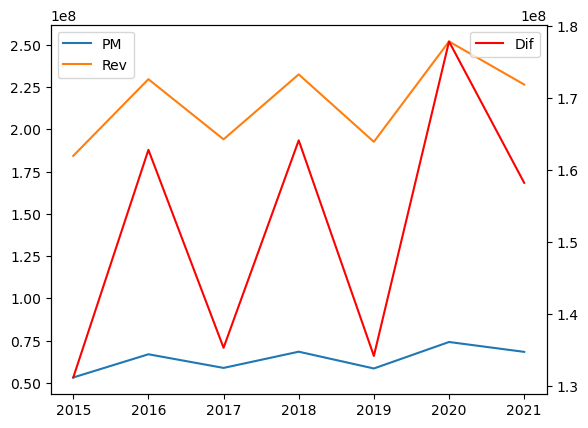

In [34]:
# Important Graph showing the relationship between the Rev, PM, and COGS

PR_df2 = PM_Rev_df[PM_Rev_df.index != 2022]
PR_df2['dif'] = PR_df2['REV'] - PR_df2['PM']

x = PR_df2.index
y1 = PR_df2['PM']
y2 = PR_df2['REV']
y3 = PR_df2['dif']

plt.plot(x, y1, label='PM')
plt.plot(x, y2, label='Rev')
plt.legend(loc='upper left')
ax2 = plt.gca().twinx()
ax2.plot(x, y3, label='Dif', color='r')
ax2.legend(loc='upper right')
plt.show()


### Expenses for Scenario 1

In [35]:
Expenses = {
    'Avg_NetProfit':(3,"Not used to calc net profit"),
    'Rent': (6,10),
    'Insurance': (2,4),
    'Wages': (15,20),
    'Ads': (6,8),
    'Taxes': (13, "A fixed amount")
}

Exp_dict = {}
Exp_list = []

for i, year in enumerate(PRC_dict.keys()):
    gross = PRC_dict[year]["PM"]
    Rev = PRC_dict[year]["Rev"]
    COGS = PRC_dict[year]["COGS"]
    Year = year

    
    Rent = (random.randrange(Expenses['Rent'][0],Expenses['Rent'][1])/100)*gross
    Insurance = (random.randrange(Expenses['Insurance'][0],Expenses['Insurance'][1])/100)*gross
    Wages = (random.randrange(Expenses['Wages'][0],Expenses['Wages'][1])/100)*gross
    Ads = (random.randrange(Expenses['Wages'][0],Expenses['Wages'][1])/100)*gross
    Net = gross - (Rent+Insurance+Wages+Ads)
    EBIT = (1 - (Expenses['Taxes'][0]/100)) * Net
    Tax = (Expenses['Taxes'][0]/100) * Net
    Net_In = EBIT - Tax

    Exp_dict = {'Year':Year,'Rev':Rev,'COGS':COGS,'Gross_Profit':gross,'Rent':Rent,'Insurance':Insurance,'Wages':Wages,'Ads':Ads,'Net_Profit':Net,'EBIT': EBIT, 'Taxes':Tax, 'Net_Income': Net_In}
    Exp_list.append(Exp_dict)


Exp_df = pd.DataFrame(Exp_list)

print(Exp_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          8 non-null      int64  
 1   Rev           8 non-null      float64
 2   COGS          8 non-null      float64
 3   Gross_Profit  8 non-null      float64
 4   Rent          8 non-null      float64
 5   Insurance     8 non-null      float64
 6   Wages         8 non-null      float64
 7   Ads           8 non-null      float64
 8   Net_Profit    8 non-null      float64
 9   EBIT          8 non-null      float64
 10  Taxes         8 non-null      float64
 11  Net_Income    8 non-null      float64
dtypes: float64(11), int64(1)
memory usage: 900.0 bytes
None


In [36]:
# Individual Expenses

num_years = len(Exp_df['Year'])
num_months = num_years*12

rent = Exp_df['Rent'].sum() / num_months
Insurance = Exp_df['Insurance'].sum() / num_months
Wages = Exp_df['Wages'].sum() / num_months

end_date = pd.Timestamp('2021-12-31')
end_year_str = str(end_date)[:4]

# Struct of List - Year, Date, Amount, Description
Comp_Exp_List = []


for year in Exp_df['Year']:
  if int(year) <= int(end_year_str):

    # Rent
    for month in range(12):
      Year = year
      Date = f"{month+1}/1/{Year}"
      Amount = rent
      Description = "Rent"
      sub_dict = {'Year':Year, 'Date':Date, 'Amount':Amount, 'Description':Description}
      Comp_Exp_List.append(sub_dict)

    # Insurance
    for month in range(12):
      Year = year
      Date = f"{month+1}/1/{Year}"
      Amount = Insurance
      Description = "Prepaid Insurance Exp"
      sub_dict = {'Year':Year, 'Date':Date, 'Amount':Amount, 'Description':Description}
      Comp_Exp_List.append(sub_dict)

    # Wages
    for month in range(12):
      Year = year
      Date = f"{month+1}/30/{Year}" # in the future it can be twice a month for 2 week pay
      Amount = Wages
      Description = "Wages payable Exp"
      sub_dict = {'Year':Year, 'Date':Date, 'Amount':Amount, 'Description':Description}
      Comp_Exp_List.append(sub_dict)

    # Ads
    # Determine how many expenses per year
    No_Ads = random.randrange(3,12)
    Ad_yrly = Exp_df[Exp_df['Year'] == year]['Ads'].iloc[0]
    amounts = []
    adj_amounts = []
    days = []
    months = []

    for ad in range(No_Ads):
      Day = random.randrange(1,28)
      month = random.randrange(1,12)
      amount = random.randint(1,100)
      amounts.append(amount)
      days.append(Day)
      months.append(month)

    amount_total = sum(amounts)

    for amount in amounts:
      amount = (amount/amount_total)*Ad_yrly
      adj_amounts.append(amount)

    for month, day, amount in zip(months,days,adj_amounts):
      Year = year
      Date = f"{month}/{Day}/{Year}"
      Amount = amount
      Description = "Ad Expense"
      sub_dict = {'Year':Year, 'Date':Date, 'Amount':Amount, 'Description':Description}
      Comp_Exp_List.append(sub_dict)
  else:
    pass

Comp_Exp_df = pd.DataFrame(Comp_Exp_List)
print(Comp_Exp_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         296 non-null    int64  
 1   Date         296 non-null    object 
 2   Amount       296 non-null    float64
 3   Description  296 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 9.4+ KB
None


# Financial Reporting

## Journal Entries